# Transformation of plasmids in 96-well format
## Protocol Initialization
Ensure you have calibrated the pipettes before doing this protocol

In [1]:
from opentrons import simulate, execute
import json
import time

When running the protocol with a robot, replace "simulate" below with "execute"

In [2]:
protocol = simulate.get_protocol_api('2.13')
protocol.home()

C:\Users\Felipe\.opentrons\robot_settings.json not found. Loading defaults
C:\Users\Felipe\.opentrons\deck_calibration.json not found. Loading defaults


## Declaring Labware
- **Left mount**: An 8-channel p20 pipette
- **Right mount**: An 8-channel p300 pipette
- **Slot 1**: DNA plate (96-well PCR plate)
- **Slot 3 (don't place the plate here yet)**: Competent cell plate on temperature module (96-well PCR plate)
- **Slots 4 and 7**: Tipracks for both pipettes
- **Slot 5**: 12-well reservoir for LB

Replace with appropriate labware codes in the cell below if needed
If you need to use custom labware, use our [Jupyter Notebook protocols tutorial](https://openplant.github.io/openplant_automation_protocols/Tutorials/Jupyter%20Notebooks/)

In [3]:
dna_plate = protocol.load_labware('biorad_96_wellplate_200ul_pcr', '1')

thermo_block = protocol.load_module('temperature module gen2', '3')
cells_plate = thermo_block.load_labware('biorad_96_wellplate_200ul_pcr')

# Here using 12-well reservoir for a max volume of 20mL.
# Since a 96-well run would use almost 18mL, it might be advisable to use a 1-well reservoir 
with open('custom_labware/enzymax_12_reservoir_20ml.json') as labware_file:
    labware_def = json.load(labware_file)
    lb_res = protocol.load_labware_from_definition(labware_def, 5)

tipracks_20 = [protocol.load_labware('opentrons_96_tiprack_20ul', '4')]
tipracks_300 = [protocol.load_labware('opentrons_96_tiprack_300ul', '7')]    

p20_8 = protocol.load_instrument('p20_multi_gen2', 'left', tip_racks=tipracks_20)
p300_8 = protocol.load_instrument('p300_multi_gen2', 'right', tip_racks=tipracks_300)

# Define the number of samples here
- Run the next cell and fill out the prompts
- You can use from 1 to 96 samples. Do note that using non-multiples of 8 will still make the robot use a whole column of pipette tips.

In [4]:
samples_no = int(input("Number of samples: "))
final_volume = int(input("What volume do you want the cells to be in at the end? (in ul, max 200) "))

if samples_no - 1 in range(96):
    columns_no = samples_no//8
    if samples_no % 8 > 0:
        columns_no += 1
else:
    samples_no = 0
    print('Invalid number of samples')

Number of samples: 96
What volume do you want the cells to be in at the end? (in ul, max 200) 100


## Labware Calibration

Change the x, y, and z variables (**in mm**) in the "set_offset" functions and run each cell repeatedly until the positioning is correct for that piece of labware. You will have to use a "dummy" plate to calibrate the labware that is not on the deck yet (competent cells).

### Tipracks:

In [5]:
protocol.comment('--- CALIBRATION ---')

In [6]:
tipracks_20[0].set_offset(x=0.0,y=0.0,z=0.0)
p20_8.move_to(tipracks_20[0]['A1'].top())

<InstrumentContext: p20_multi_v2.0 in LEFT>

In [7]:
tipracks_300[0].set_offset(x=0.0,y=0.0,z=0.0)
p300_8.move_to(tipracks_300[0]['A1'].top())

<InstrumentContext: p300_multi_v2.0 in RIGHT>

### Plates/Racks:

In [8]:
p20_8.pick_up_tip()

<InstrumentContext: p20_multi_v2.0 in LEFT>

In [9]:
dna_plate.set_offset(x=0.0,y=0.0,z=0.0)
p20_8.move_to(dna_plate['A1'].top())

<InstrumentContext: p20_multi_v2.0 in LEFT>

- Use a dummy plate to calibrate the cell below

In [10]:
cells_plate.set_offset(x=0.0,y=0.0,z=0.0)
p20_8.move_to(cells_plate['A1'].top())

<InstrumentContext: p20_multi_v2.0 in LEFT>

In [11]:
lb_res.set_offset(x=0.0,y=0.0,z=0.0)
p20_8.move_to(lb_res['A1'].top())

<InstrumentContext: p20_multi_v2.0 in LEFT>

In [12]:
p20_8.return_tip()
p20_8.reset_tipracks()

## Protocol Execution

In [13]:
print("Setting temperature to 4°C")
thermo_block.set_temperature(4)
print('Done')

Setting temperature to 4°C
Done


- Place the plate with competent cells on the temperature module
- Run the next cell immediately

In [14]:
protocol.comment('--- TRANSFERRING DNA INTO COMPETENT CELLS ---')
print(protocol.commands()[-1])
print('10 minutes wait started at', time.strftime("%H:%M:%S", time.localtime()))
protocol.delay(minutes=10)
for col in range(columns_no):
    print('Transferring column', col + 1)
    p20_8.pick_up_tip()
    p20_8.aspirate(5, dna_plate.rows()[0][col])
    p20_8.dispense(5, cells_plate.rows()[0][col].bottom(z=1.5))
    p20_8.mix(3, 10, cells_plate.rows()[0][col])
    p20_8.touch_tip()
    p20_8.drop_tip()
print("Done")

--- TRANSFERRING DNA INTO COMPETENT CELLS ---
10 minutes wait started at 14:41:31
Transferring column 1
Transferring column 2
Transferring column 3
Transferring column 4
Transferring column 5
Transferring column 6
Transferring column 7
Transferring column 8
Transferring column 9
Transferring column 10
Transferring column 11
Transferring column 12
Done


 - Put cells plate on ice and carry to a thermocycler for heat shock program:
    - 20 min 4°C
    - 45 sec 42°C
- Run the next cell
- Move back to the OT2 (temperature module)

In [15]:
thermo_block.deactivate()

In [16]:
protocol.comment('--- TRANSFERRING LB INTO CELLS PLATE ---')
print(protocol.commands()[-1])

thermo_block.set_temperature(4)

p300_8.pick_up_tip()
for col in range(columns_no):
    print('Transferring column', col + 1)
    p300_8.aspirate(final_volume - 15, lb_res.rows()[0][0])
    p300_8.dispense(final_volume - 15, cells_plate.rows()[0][col].top()) # I removed the touch tip here, and am dispensing from the top of the well to avoid contamination
    p300_8.move_to(lb_res.rows()[0][0].top())
    p300_8.blow_out()
p300_8.drop_tip()
print('Done')

--- TRANSFERRING LB INTO CELLS PLATE ---
Transferring column 1
Transferring column 2
Transferring column 3
Transferring column 4
Transferring column 5
Transferring column 6
Transferring column 7
Transferring column 8
Transferring column 9
Transferring column 10
Transferring column 11
Transferring column 12
Done


In [17]:
protocol.home()

In [18]:
protocol.commands()

['--- CALIBRATION ---',
 'Moving to A1 of Opentrons 96 Tip Rack 20 µL on 4',
 'Moving to A1 of Opentrons 96 Tip Rack 300 µL on 7',
 'Picking up tip from A1 of Opentrons 96 Tip Rack 20 µL on 4',
 'Moving to A1 of Bio-Rad 96 Well Plate 200 µL PCR on 1',
 'Moving to A1 of Bio-Rad 96 Well Plate 200 µL PCR on Temperature Module GEN2 on 3',
 'Moving to A1 of Enzymax 12 Well Reservoir 20 mL on 5',
 'Returning tip',
 'Dropping tip into A1 of Opentrons 96 Tip Rack 20 µL on 4',
 'Setting Temperature Module temperature to 4.0 °C (rounded off to nearest integer)',
 '--- TRANSFERRING DNA INTO COMPETENT CELLS ---',
 'Delaying for 10 minutes and 0.0 seconds',
 'Picking up tip from A1 of Opentrons 96 Tip Rack 20 µL on 4',
 'Aspirating 5.0 uL from A1 of Bio-Rad 96 Well Plate 200 µL PCR on 1 at 7.6 uL/sec',
 'Dispensing 5.0 uL into A1 of Bio-Rad 96 Well Plate 200 µL PCR on Temperature Module GEN2 on 3 at 7.6 uL/sec',
 'Mixing 3 times with a volume of 10.0 ul',
 'Aspirating 10.0 uL from A1 of Bio-Rad 96 

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

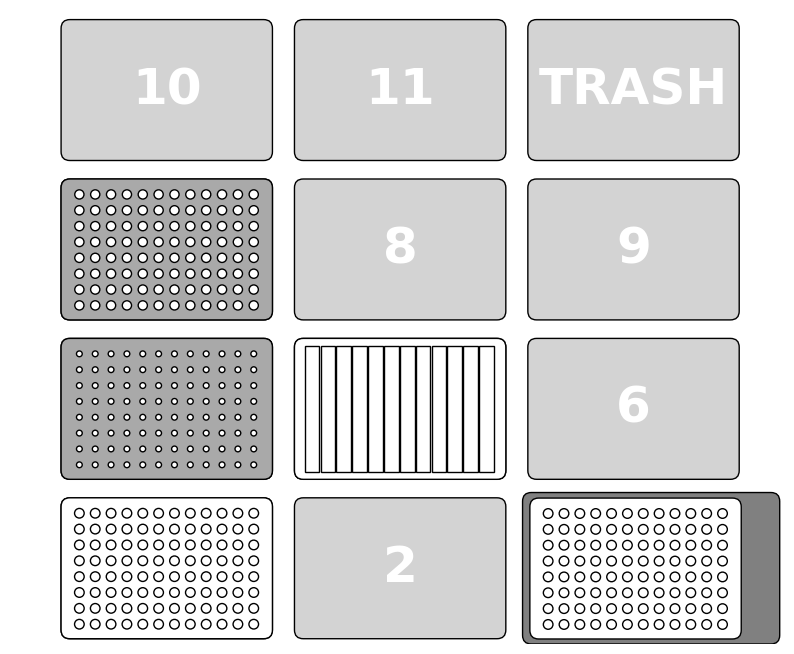

In [20]:
fig, ax = plt.subplots(1, figsize=(10, 10))

deck_positions = {1:(4, 3), 2:(136.5, 3), 3:(269, 3),
                  4:(4, 93.5), 5:(136.5, 93.5), 6:(269, 93.5),
                  7:(4, 184), 8:(136.5, 184), 9:(269, 184),
                  10:(4, 274.5), 11:(136.5, 274.5), 12:(269, 274.5)}

for pos, coords in deck_positions.items():    
    rect = patches.FancyBboxPatch((coords[0],coords[1]),
                                  120, 80,
                                  boxstyle='round, rounding_size=5, pad=0',
                                  facecolor='lightgrey',
                                  zorder=0)
    ax.add_patch(rect)
    
    if pos == 12:
        pos = 'TRASH'
    
    plt.text(coords[0]+60, coords[1]+40, str(pos),
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=36,
             fontweight='bold',
             color='w',
             zorder=1)

for name, mod in protocol.loaded_modules.items():
    mod_w = 146
    mod_h = 86
    if name in [1, 4, 7, 10]:
        if mod.geometry.module_type == 'thermocyclerModuleType':
            x_off = 0
            mod_w = 160
            mod_h = 175
        else:
            x_off = -20
    elif name in [3, 6, 9]:
        x_off = 0
    rect = patches.FancyBboxPatch((deck_positions[name][0]+x_off-3,deck_positions[name][1]-3),
                                  mod_w, mod_h,
                                  boxstyle='round, rounding_size=5, pad=0',
                                  facecolor='grey',
                                  zorder=1
                                 )
    ax.add_patch(rect)

for name, obj in protocol.loaded_labwares.items():
    if name != 12:
        if obj.is_tiprack:
            color = 'darkgrey'
        else:
            color = 'w'
        lab_x = obj.calibrated_offset.x + 4
        lab_y = obj.calibrated_offset.y + 3
        rect = patches.FancyBboxPatch((lab_x,lab_y),
                                      120, 80,
                                      boxstyle='round, rounding_size=5, pad=0',
                                      linewidth=1,
                                      facecolor=color)
        ax.add_patch(rect)
        for well in obj.wells():
            well_x = well.geometry.position.x
            well_y = well.geometry.position.y
            if well.diameter != None:
                circ = patches.Circle((well_x, well_y),
                                      well.diameter/2,
                                      linewidth=1,
                                      edgecolor='k',
                                      facecolor='w')
                ax.add_patch(circ)
            else:
                well_h = well.width
                well_w = well.length
                rect = patches.Rectangle((well_x-well_w/2, well_y-well_h/2),
                                         well_w, well_h,
                                         linewidth=1,
                                         edgecolor='k',
                                         facecolor='w')
                ax.add_patch(rect)

plt.xlim(-25, 415)
plt.ylim(0, 360)
ax.set_axis_off()
ax.set_aspect('equal', adjustable='box')

plt.show()